In [1]:
# Libraries
## Mathematics
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

## Visualization
import matplotlib.pyplot as plt

In [2]:
# Load functions .py files
from Practical_case_functions import EM_Algorithm, KDE
from Visualisation import OSB_visualisation
from Checking_simulated_boundary_functions_3 import optimal_stopping_montecarlo_3

# Data preparation

In [3]:
# Read data
df_options = pd.read_csv("Data/aapl_2016_2020.csv", sep=',', header=0, low_memory = False)
df_stock = pd.read_csv("Data/AAPL.csv", sep=',', header=0, low_memory = False)

## Options dataframe preprocessing

In [4]:
# Filter columns of the options
df_options1 = df_options[[' [QUOTE_DATE]', ' [EXPIRE_DATE]', ' [C_VOLUME]', ' [STRIKE]', ' [P_VOLUME]']]

# Rename columns
df_options1.columns = ['Issuance date', 'Expiration date', 'Call volume', 'Strike price', 'Put volume']

# Keep only the options from 2022-07-01 to 2022-08-01
df_options1['Issuance date'] = pd.to_datetime(df_options1['Issuance date'])
df_options1['Expiration date'] = pd.to_datetime(df_options1['Expiration date'])
df_options2 = df_options1[(df_options1['Issuance date'] == '2019-01-02') & (df_options1['Expiration date'] == '2019-02-01')]

# Replace " " with 0
df_options3 = df_options2.replace(" ", 0)

# Convert volumes to numeric (in case they were strings)
df_options3["Call volume"] = pd.to_numeric(df_options2["Call volume"], errors='coerce').fillna(0)
df_options3["Put volume"] = pd.to_numeric(df_options2["Put volume"], errors='coerce').fillna(0)

# Reset the index
df_options4 = df_options3.reset_index(drop=True)

# Add total volume
df_options4["Total volume"] = df_options4["Call volume"] + df_options4["Put volume"]
df_options_final = df_options4

# Visualisation final dataset
df_options_final.head()

C:\Users\User\AppData\Local\Temp\ipykernel_1804860\586929124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options1['Issuance date'] = pd.to_datetime(df_options1['Issuance date'])
C:\Users\User\AppData\Local\Temp\ipykernel_1804860\586929124.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options1['Expiration date'] = pd.to_datetime(df_options1['Expiration date'])


,Issuance date,Expiration date,Call volume,Strike price,Put volume,Total volume
0,2019-01-02,2019-02-01,0.0,100.0,1.0,1.0
1,2019-01-02,2019-02-01,0.0,105.0,1.0,1.0
2,2019-01-02,2019-02-01,0.0,110.0,11.0,11.0
3,2019-01-02,2019-02-01,2.0,115.0,17.0,19.0
4,2019-01-02,2019-02-01,0.0,120.0,39.0,39.0


## Stock dataframe preprocessing

In [5]:
# Filter columns of the stocks
df_stocks1 = df_stock.drop(["Adj Close", "Volume"], axis = 1)

# Keep only the stocks from 2022-07-01 to 2022-08-01
df_stocks1['Date'] = pd.to_datetime(df_stocks1['Date'])
df_stocks2 = df_stocks1[(df_stocks1['Date'] >= '2019-01-02') & (df_stocks1['Date'] <= '2019-02-01')]
df_stocks2.head()

# Replace " " with 0
df_stocks3= df_stocks2.replace(" ", 0)

# Convert volumes to numeric (in case they were strings)
df_stocks3["Open"] = pd.to_numeric(df_stocks3["Open"], errors='coerce').fillna(0)
df_stocks3["High"] = pd.to_numeric(df_stocks3["High"], errors='coerce').fillna(0)
df_stocks3["Low"] = pd.to_numeric(df_stocks3["Low"], errors='coerce').fillna(0)
df_stocks3["Close"] = pd.to_numeric(df_stocks3["Close"], errors='coerce').fillna(0)

# Reset the index
df_stocks4 = df_stocks3.reset_index(drop=True)

# Add Middle
df_stocks4["Middle"] = (df_stocks4["High"] + df_stocks4["Low"])/2
df_stocks_final = df_stocks4

# Visualisation final dataset
df_stocks_final

,Date,Open,High,Low,Close,Middle
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,39.135001
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,35.965000
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.543751
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.841249
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,37.542502
5,2019-01-09,37.822498,38.632500,37.407501,38.327499,38.020001
6,2019-01-10,38.125000,38.492500,37.715000,38.450001,38.103750
7,2019-01-11,38.220001,38.424999,37.877499,38.072498,38.151249
8,2019-01-14,37.712502,37.817501,37.305000,37.500000,37.561250
9,2019-01-15,37.567501,38.347500,37.512501,38.267502,37.930000


## Volatility estimation and rescaling

In [6]:
# Choose the stock price of the time series as a pandas Series
Z_hat = df_stocks_final["Middle"]

# Calculate logarithmic returns
log_returns = np.log(Z_hat / Z_hat.shift(1)).dropna()

# Calculate volatility (standard deviation of log returns)
volatility = log_returns.std()

# Rescaling
Z = (Z_hat-Z_hat[0])/volatility
df_options_final['Strike price'] = (df_options_final['Strike price']-Z_hat[0])/volatility

# Extract Z_1
Z_1 = np.array(df_options_final['Strike price'])

# Density estimation

## EM Algorithm

In [7]:
# EM Algorithm
weights_EM, parameters_EM = EM_Algorithm(Z_1 = Z_1, n_components = "BIC", n_components_trials = 15)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

The lowest BIC was achieved with 1 components.


## KDE

In [8]:
# KDE 
weights_KDE, parameters_KDE = KDE(Z_1 = Z_1)

# Boundary obtention

## EM Algorithm

In [9]:
# OSB estimation
# Temporal mesh
mesh = 10
t_mesh = np.linspace(0, 1, mesh) # Temporal grid

# Spatial grid
L = 12500

# Boundary
np.random.seed(123)
value_function_EM, X_vals_EM = optimal_stopping_montecarlo_3(mu = "continuous", weights = weights_EM, parameters = parameters_EM, N = mesh, a = min(Z_1)-1, b = max(Z_1)+1, L = L, M = 4500)

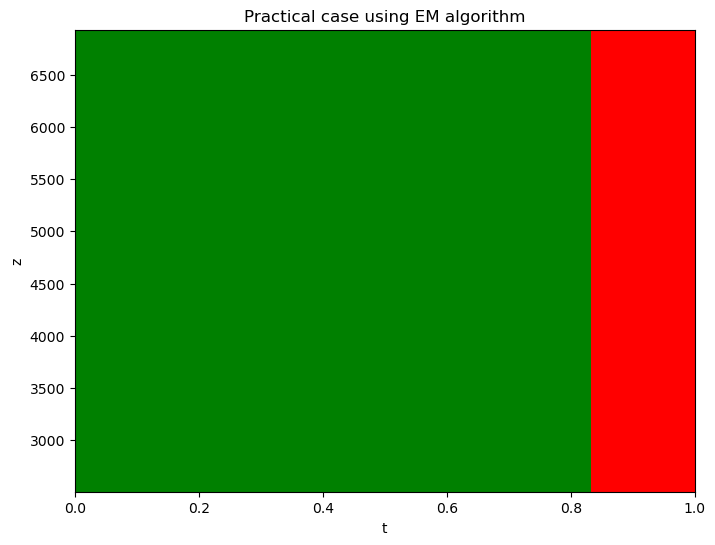

In [10]:
# Plotting
OSB_visualisation(N = mesh, value_function = value_function_EM, X_vals = X_vals_EM, title = "Practical case using EM algorithm", name = "Practical_case_EM.png")

## KDE

In [11]:
# OSB estimation
# Temporal mesh
mesh = 10
t_mesh = np.linspace(0, 1, mesh) # Temporal grid

# Spatial grid
L = 12500

# Boundary
np.random.seed(123)
value_function_KDE, X_vals_KDE = optimal_stopping_montecarlo_3(mu = "continuous", weights = weights_KDE, parameters = parameters_KDE, N = mesh, a = min(Z_1)-1, b = max(Z_1)+1, L = L, M = 4500)

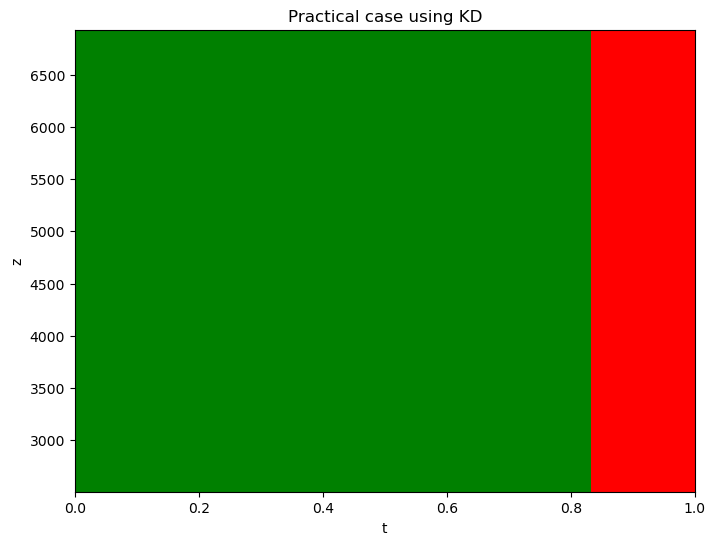

In [12]:
# Plotting
OSB_visualisation(N = mesh, value_function = value_function_KDE, X_vals = X_vals_KDE, title = "Practical case using KD", name = "Practical_case_KDE.png")